# Increasing output font size

In [22]:
# Increase font size
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '20px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

<IPython.core.display.Javascript object>

# Loading libraries, datasets, and helper methods

## Check CUDA and CUDNN versions

In [1]:
!nvidia-smi
!nvcc -V
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

Fri Feb 26 17:35:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Initialize path and options

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab/MimickNet_Mobile

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/Colab/MimickNet_Mobile'
/content/gdrive/My Drive/Colab/MimickNet_Mobile


## Get dependencies

In [3]:
%%capture
# Install libraries
!pip3 install tensorflow==2.3.0
!pip3 install tensorflow_datasets
!pip3 install tensorflow_addons==0.8.3
!pip3 install tensorflow-gpu
!pip3 install polarTransform
%tensorflow_version 2.x

In [4]:
%%capture
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import polarTransform
import time

# Import helpers
from trainer.config import config
from trainer import utils
from trainer import models
from trainer import callbacks
from trainer.utils import *

# Hide warnings
# import warnings
# warnings.filterwarnings('ignore')

## Load Helper Functions, Datasets, and Models

In [5]:
# Load Dataset
class MimickDataset():
    def __init__(self, divisible, bs, dataset, data_dir):
        self.divisible = divisible
        self.bs = bs
        self.dataset = dataset
        self.data_dir = data_dir

    def make_dataset(self, dataset_type):
        ds = tfds.load(self.dataset, data_dir=self.data_dir)
        dataset = ds[dataset_type]
        dataset = dataset.map(process)

        if (dataset_type == 'train' or dataset_type == 'validation'):
            dataset = dataset.map(make_shape_to_dimension, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
            dataset = dataset.batch(self.bs).repeat().prefetch(1)
        else:
            dataset = dataset.map(make_divisible, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
            dataset = dataset.repeat().prefetch(1)
        # dataset = dataset.apply(tf.data.experimental.prefetch_to_device("/gpu:0", buffer_size=1))
        return dataset

# Create datasets (Train, Validation, Test)
mimick = MimickDataset(divisible=16, bs=config.bs, dataset='duke_ultrasound', data_dir='gs://tfds-data/datasets')


# Make datasets, compile train and test iterators
test_dataset = mimick.make_dataset(dataset_type='test')
test_iter = iter(test_dataset)
for i in range(config.bs*10):
    next(test_iter)

train_dataset = mimick.make_dataset(dataset_type='train')
train_iter = iter(train_dataset)
for i in range(config.bs*10):
    next(train_iter)

In [6]:
# Load Models
model_Conv = tf.keras.models.load_model('./example_models/model_Conv.h5',
                                        custom_objects={
                                        'ssim': utils.ssim,
                                        'psnr': utils.psnr,
                                        })
model_SepConv = tf.keras.models.load_model('./example_models/model_SepConv.h5',
                                           custom_objects={
                                        'ssim': utils.ssim,
                                        'psnr': utils.psnr,
                                        })


In [7]:
# New Scan Convert function
def scan_convert_new(image, ele):
    y_seg = 17
    x_seg = 5
    output_test, start_points, end_points, irad, frad = scan_convert_tf(image, ele, y_seg, x_seg)
    res = fan_out_tf(output_test, start_points, end_points, irad, frad)
    return res

@tf.function
def scan_convert_tf(image, ele, y_seg, x_seg):
    '''All coordinates are set as [y,x]'''

    # Initialize variables
    height, width = image.shape[1], image.shape[2]
    irad, frad = ele['initial_radius'], ele['final_radius']
    iang, fang, = ele['initial_angle'], ele['final_angle']

    # Pad image
    horizontal_pad = tf.math.floor(frad*tf.sin(fang) - width/2)
    vertical_pad = tf.math.floor(irad)
    image_padded = tf.pad(image, [[0,0], 
                                    [vertical_pad, 0], 
                                    [horizontal_pad-2, horizontal_pad-2], 
                                    [0,0]], 
                                    "CONSTANT")
    
    # Initialize start points
    y = tf.cast(tf.linspace(0, height, y_seg), tf.float32) + vertical_pad
    x = tf.cast(tf.linspace(0, width, x_seg), tf.float32) + horizontal_pad
    x, y = tf.meshgrid(x, y)
    y, x = tf.reshape(y, [-1]), tf.reshape(x, [-1])
    start_points = tf.stack([y,x], axis=-1)

    # Generate end points
    angles = tf.linspace(-1.0, 1.0, x_seg) * fang
    angles = tf.tile(angles , tf.constant([y_seg], tf.int32))
    y_coords = start_points[:,0]
    y_converted = y_coords - y_coords * (1-tf.cos(angles)) # y coordinates conversion
    x_converted = (horizontal_pad + width/2) + y_coords * tf.sin(angles)   # x coordinates conversion
    end_points = tf.stack([y_converted, x_converted], axis=-1)

    # Return padded image, start points, and end points
    start_points = tf.expand_dims(start_points, axis=0)
    end_points = tf.expand_dims(end_points, axis=0)
    return image_padded, tf.round(start_points), tf.round(end_points), tf.cast(irad, tf.int32), tf.cast(frad, tf.float32)

@tf.function
def fan_out_tf(image_padded, start_points, end_points, irad, frad):
    # Returns a fanout using padded image, start points, and end points
    res, _ = tfa.image.sparse_image_warp(image_padded, start_points, end_points)

    # Creating mask to remove artifacts from sparse warp
    height, width = image_padded.shape[1], image_padded.shape[2]
    X, Y = tf.meshgrid(tf.linspace(0, width, width), tf.linspace(0, height, height))
    dist_from_center = tf.cast(tf.sqrt((X - width/2)**2 + (Y - 0)**2), tf.float32)
    mask = dist_from_center <= frad
    mask = tf.expand_dims(mask, axis=0)
    mask = tf.expand_dims(mask, axis=3)
    zeros = tf.zeros(shape=(1,height,width,1))

    # Masking result image
    res = tf.where(mask, res, zeros)
    return res[:,irad:,:,:]

# Original Scan Convert function
def scan_convert_old_helper(image, irad, frad, iang, fang):
    """Scan converts beam lines"""
    image, _ = polarTransform.convertToCartesianImage(
        np.transpose(image),
        initialRadius=irad,
        finalRadius=frad,
        initialAngle=iang,
        finalAngle=fang,
        hasColor=False,
        order=1)
    return np.transpose(image[:, int(irad):])

def scan_convert_old(data, ele):
    return scan_convert_old_helper(data, ele['initial_radius'].numpy(),
                                    ele['final_radius'].numpy(),
                                    ele['initial_angle'].numpy(),
                                    ele['final_angle'].numpy())

In [8]:
# @title Progress in works of further optimizing scan convert (reducing memory req and placing everything into one @tf.function) {form-width:"33%"}
# def scan_convert_new(image, ele):
#     ''' Initialize variables '''
#     ''' Math obtained here: https://math.stackexchange.com/questions/332743/calculating-the-coordinates-of-a-point-on-a-circles-circumference-from-the-radiu '''

#     height = tf.cast(tf.shape(ele['das'])[0], tf.int32)
#     width = tf.cast(tf.shape(ele['das'])[1], tf.int32)

#     horizontal_pad = tf.cast((2048 - width) / 2, tf.int32)
#     vertical_pad = tf.cast(2048 - height, tf.int32)
#     x_segments = 5
#     y_segments = 17

#     ''' Pad Images with calculated pads to obtain 2048 to 2048 '''
#     temp_output = tf.pad(image, [[vertical_pad, 0], 
#                                 [horizontal_pad, horizontal_pad]], 
#                                 "CONSTANT", constant_values = 0)

#     ''' Obtain start and end points '''
#     # Initialize start points
#     y = tf.cast(tf.linspace(0, height, y_segments), tf.int32) + vertical_pad
#     x = tf.cast(tf.linspace(0, width, x_segments), tf.int32) + horizontal_pad
#     x, y = tf.meshgrid(x, y)
#     y, x = tf.reshape(y, [-1]), tf.reshape(x, [-1])
#     start_points = tf.stack([y,x], axis=-1)
#     start_points = tf.cast(tf.round(start_points), tf.float32)

#     # Generate end points
#     angles = tf.linspace(-1.0, 1.0, x_segments) * ele['final_angle']
#     angles = tf.tile(angles , tf.constant([y_segments], tf.int32))
#     y_coords = start_points[:,0]
#     rad = tf.linspace(ele['initial_radius'], ele['final_radius'], y_segments)
#     rad = tf.repeat(rad, x_segments)
#     y_converted = y_coords - rad * (1-tf.cos(angles)) # y coordinates conversion
#     x_converted = (tf.cast(horizontal_pad, tf.float32) + tf.cast(width/2, tf.float32)) + rad * tf.sin(angles)   # x coordinates conversion
#     end_points = tf.stack([y_converted, x_converted], axis=-1)
#     end_points = tf.cast(tf.round(end_points), tf.float32)

#     # Add batch dimensions for start and end points
#     start_points = tf.expand_dims(start_points, axis=0)
#     end_points = tf.expand_dims(end_points, axis=0)

#     '''Image Sparse Warp (to create scan convert image)'''
#     # First ensure padded shape is set as 4096 and 4096 with batch size 1
#     # and channels as 1.
#     # Shape must be set beforehand or else sparse warp will fail
#     temp_output = tf.expand_dims(temp_output, axis=0)
#     temp_output = tf.expand_dims(temp_output, axis=3)
#     temp_output = tf.ensure_shape(temp_output, shape=(1,2048,2048,1))

#     # Image sparse warp to create scan convert images
#     temp_output, _ = tfa.image.sparse_image_warp(temp_output, start_points, end_points)

#     ''' Add mask to remove artifacts '''
#     height, width = tf.shape(temp_output)[1], tf.shape(temp_output)[2]
#     X, Y = tf.meshgrid(tf.linspace(0, width, width), tf.linspace(0, height, height))
#     X, Y = tf.cast(X, tf.float32), tf.cast(Y, tf.float32)
#     dist_from_center = tf.cast(tf.sqrt((X - tf.cast(width/2, tf.float32))**2 + (Y - (2048.0-ele['final_radius']))**2), tf.float32)
#     mask = dist_from_center <= ele['final_radius']
#     mask = tf.expand_dims(mask, axis=0)
#     mask = tf.expand_dims(mask, axis=3)
#     zeros = tf.zeros(shape=(1,height,width,1))
#     temp_output = tf.where(mask, temp_output, zeros)

#     ''' Trim off extra areas '''
#     maxX = tf.math.multiply(ele['final_radius'], tf.sin(ele['final_angle']))
#     minX = tf.math.multiply(ele['final_radius'], tf.sin(ele['initial_angle']))

#     temp_output = tf.image.resize_with_crop_or_pad(temp_output, 2048, tf.cast(maxX-minX, tf.int32))
#     temp_output = temp_output[:,vertical_pad:,:,:]

#     return tf.squeeze(temp_output)

# Testing speed

## Test speed of pipeline (inference -> scan convert)

Four different methods are tested:

* Old scan convert -> MimickNet with Conv
* Old scan convert -> MimickNet with SepConv
* New scan convert -> MimickNet with Conv
* New scan convert -> MimickNet with SepConv


In [25]:
# @title {form-width:"10%"}
def MimickNet_Mobile_speed_test(new_SC, test_with_sepConv, compile):
    tf.keras.backend.clear_session()
    string_result = []

    if not test_with_sepConv:
        string_result.append("Conv2D")
    elif test_with_sepConv:
        string_result.append("SepConv2D")
    if not new_SC:
        string_result.append("Old Scan Convert")
    elif new_SC:
        string_result.append("New Scan Convert")

    # Start timing
    t_speed_test_start = time.perf_counter() 

    input_image = tf.expand_dims(test_ele['das'], axis=0)

    if not test_with_sepConv:
        inference_image = model_Conv(input_image)
    elif test_with_sepConv:
        inference_image = model_SepConv(input_image)
    if not new_SC:
        output = scan_convert_old(tf.squeeze(inference_image), test_ele)
    elif new_SC:
        output = scan_convert_new(inference_image, test_ele)

    t_speed_test_stop = time.perf_counter()
    string_result.append(str((t_speed_test_stop - t_speed_test_start)))
    if compile: return
    print("Test for {} with {}; average time taken: {} seconds".format(*string_result))
    return

test_ele = next(test_iter)
MimickNet_Mobile_speed_test(new_SC=False, test_with_sepConv=False, compile=False)
MimickNet_Mobile_speed_test(new_SC=False, test_with_sepConv=True, compile=False)
MimickNet_Mobile_speed_test(new_SC=True, test_with_sepConv=False, compile=True) # Compile Run of New Scan Convert
MimickNet_Mobile_speed_test(new_SC=True, test_with_sepConv=False, compile=False)
MimickNet_Mobile_speed_test(new_SC=True, test_with_sepConv=True, compile=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test for Conv2D with Old Scan Convert; average time taken: 0.39814978799995515 seconds
Test for SepConv2D with Old Scan Convert; average time taken: 0.3987678280000182 seconds
Test for Conv2D with New Scan Convert; average time taken: 1.0027527420002116 seconds
Test for SepConv2D with New Scan Convert; average time taken: 0.9636675510000714 seconds


## Testing SepConv vs Conv Separately

We test inference speed of the two models with random tensor inputs of 
shape=(batchsize, height, width, 1)

For height and width, we create pairs of all elements in [128, 512, 1024]

For batch size, we test batch sizes of [1, 4, 8]

In [10]:
#@title {form-width:"10%"}
dimensions = [128, 512, 1024]
batch = [1, 4, 8]

def test_random_sepConv_conv():
    conv_testdata = np.zeros(shape=(len(dimensions),len(dimensions),len(batch)))
    sepconv_testdata = np.zeros(shape=(len(dimensions),len(dimensions),len(batch)))


    for i, height in enumerate(dimensions):
        for j, width in enumerate(dimensions):
            for k, batch_size in enumerate(batch):
                print("Testing height of {}, width of {}, and batch size of {}...".format(height, width, batch_size))
                random_image = tf.random.uniform(shape=(batch_size,height,width,1))
                t_start = time.perf_counter()
                for _ in range(config.bs):
                    inference_image = model_Conv.predict(random_image)
                t_stop = time.perf_counter()
                conv_testdata[i][j][k] = (t_stop - t_start)/config.bs

                t_start = time.perf_counter()
                for _ in range(config.bs):
                    inference_image = model_SepConv.predict(random_image)
                t_stop = time.perf_counter()
                sepconv_testdata[i][j][k] = (t_stop - t_start)/config.bs

    return conv_testdata, sepconv_testdata
    
conv_testdata, sepconv_testdata = test_random_sepConv_conv()

Testing height of 128, width of 128, and batch size of 1...
Testing height of 128, width of 128, and batch size of 4...
Testing height of 128, width of 128, and batch size of 8...
Testing height of 128, width of 512, and batch size of 1...
Testing height of 128, width of 512, and batch size of 4...
Testing height of 128, width of 512, and batch size of 8...
Testing height of 128, width of 1024, and batch size of 1...
Testing height of 128, width of 1024, and batch size of 4...
Testing height of 128, width of 1024, and batch size of 8...
Testing height of 512, width of 128, and batch size of 1...
Testing height of 512, width of 128, and batch size of 4...
Testing height of 512, width of 128, and batch size of 8...
Testing height of 512, width of 512, and batch size of 1...
Testing height of 512, width of 512, and batch size of 4...
Testing height of 512, width of 512, and batch size of 8...
Testing height of 512, width of 1024, and batch size of 1...
Testing height of 512, width of 1024

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

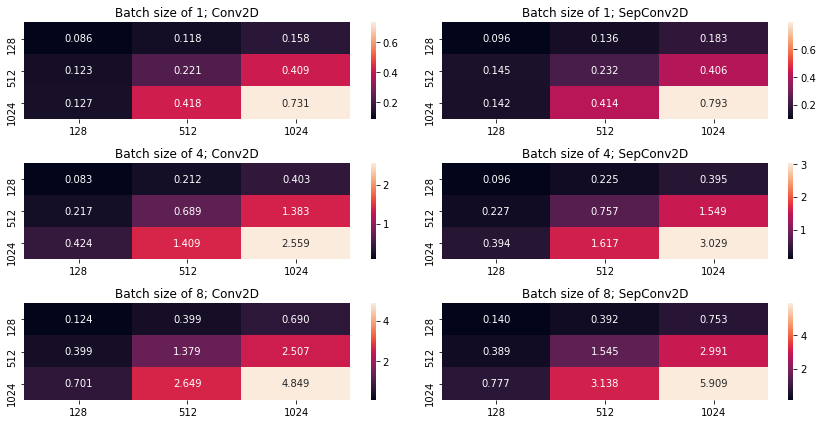

In [31]:
#@title {form-width:"10%"}
fig, axes = plt.subplots(len(batch), 2, figsize=(12, 6))
# fig.suptitle('4 row x 2 columns axes with no data')

for i in range(len(batch)):
    axes[i, 0].set_title("Batch size of {}; Conv2D".format(str(batch[i])))
    axes[i, 1].set_title("Batch size of {}; SepConv2D".format(str(batch[i])))
    sns.heatmap(ax=axes[i, 0], data=conv_testdata[:,:,i], annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dimensions, )
    sns.heatmap(ax=axes[i, 1], data=sepconv_testdata[:,:,i], annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dimensions,)
plt.tight_layout()

# Testing accuracy

## Test accuracy of processes (inference -> scan convert)

With the four different methods, we also test the accuracy of the predictions.
We do this by checking:
* SSIM
* MSE


In [27]:
#@title {form-width:"10%"}
def MimickNet_Mobile_accuracy_test(test_with_sepConv):
    tf.keras.backend.clear_session()
    ssims = []
    mses = []

    if not test_with_sepConv:
        model_type = "Conv2D"
    elif test_with_sepConv:
        model_type = "SepConv2D"

    for i in range(config.bs):
        test_ele = next(test_iter)
        input_image = tf.expand_dims(test_ele['das'], axis=0)

        if not test_with_sepConv:
            inference_image = model_Conv.predict(input_image)
        elif test_with_sepConv:
            inference_image = model_SepConv.predict(input_image)

        true_image = tf.expand_dims(test_ele['dtce'], axis=0)
        ssim = utils.ssim(true_image, inference_image).numpy()
        mse = utils.mse(true_image, inference_image).numpy()
        ssims.append(ssim[0])
        mses.append(mse[0])
    print("Test for {}; average SSIM accuracy: {}".format(model_type, str(sum(ssims)/config.bs)))
    print("Test for {}; average MSE: {}".format(model_type, str(sum(mses)/config.bs)))
    print()

MimickNet_Mobile_accuracy_test(test_with_sepConv=False)
MimickNet_Mobile_accuracy_test(test_with_sepConv=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test for Conv2D; average SSIM accuracy: 0.960194319486618
Test for Conv2D; average MSE: 0.0035067016578977928

Test for SepConv2D; average SSIM accuracy: 0.9267072528600693
Test for SepConv2D; average MSE: 0.005013110836443957



# Qualitative Data (Photos of all four processes)

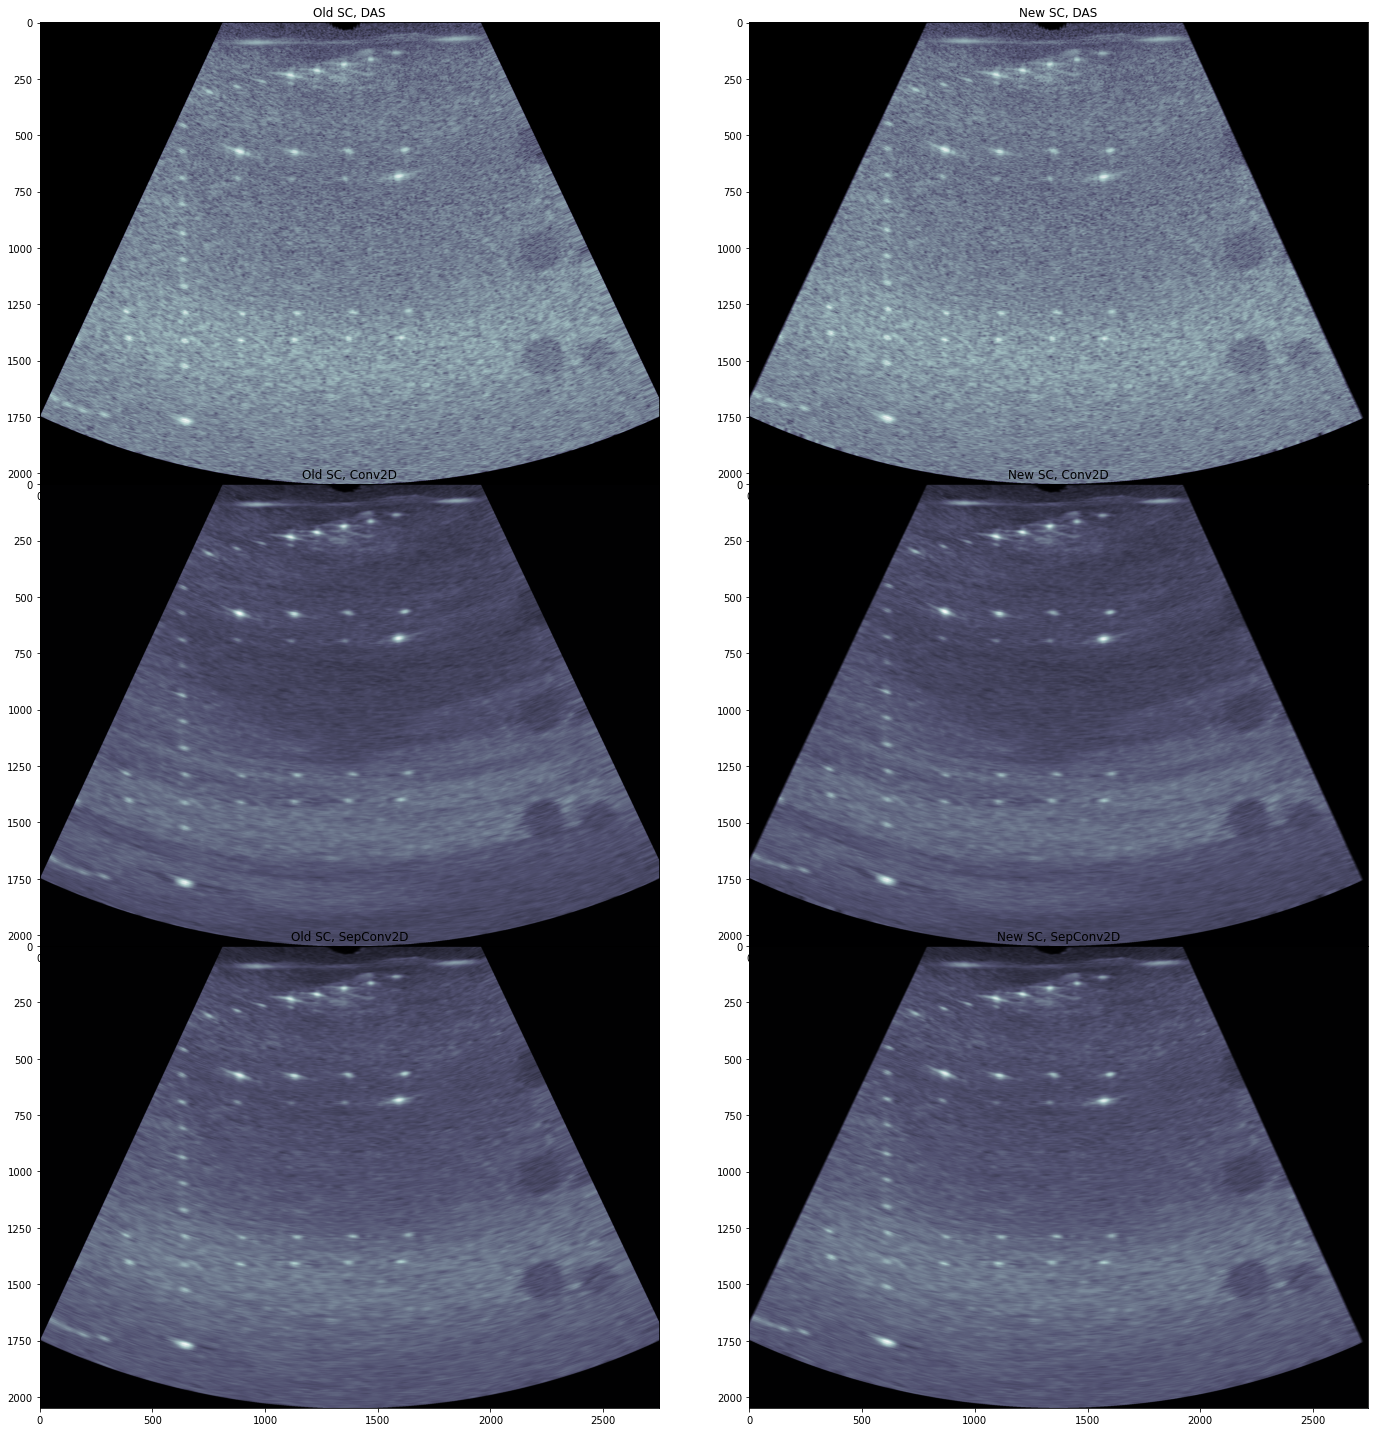

In [13]:
#@title {form-width:"10%"}
def MimickNet_Mobile_show_images():
    tf.keras.backend.clear_session()

    input_image = tf.expand_dims(test_ele['das'], axis=0)

    inference_image_conv = model_Conv.predict(input_image)
    inference_image_sepconv = model_SepConv.predict(input_image)

    input_oldSC = scan_convert_old(tf.squeeze(input_image), test_ele)
    input_newSC = scan_convert_new(input_image, test_ele)
    
    output_oldSC_conv = scan_convert_old(tf.squeeze(inference_image_conv), test_ele)
    output_oldSC_sepconv = scan_convert_old(tf.squeeze(inference_image_sepconv), test_ele)
    output_newSC_conv = scan_convert_new(inference_image_conv, test_ele)
    output_newSC_sepconv = scan_convert_new(inference_image_sepconv, test_ele)

    fig, axes = plt.subplots(3,2, figsize=(20,20), gridspec_kw={
        'wspace': 0,
        'hspace': 0
    })
    colormap = 'bone'
    axes[0,0].set_title("Old SC, DAS")
    axes[0,1].set_title("New SC, DAS")
    axes[1,0].set_title('Old SC, Conv2D')
    axes[1,1].set_title('New SC, Conv2D')
    axes[2,0].set_title('Old SC, SepConv2D')
    axes[2,1].set_title('New SC, SepConv2D')

    axes[0,0].imshow(tf.squeeze(input_oldSC), cmap=colormap)
    axes[0,1].imshow(tf.squeeze(input_newSC), cmap=colormap)
    axes[1,0].imshow(tf.squeeze(output_oldSC_conv), cmap=colormap)
    axes[1,1].imshow(tf.squeeze(output_newSC_conv), cmap=colormap)
    axes[2,0].imshow(tf.squeeze(output_oldSC_sepconv), cmap=colormap)
    axes[2,1].imshow(tf.squeeze(output_newSC_sepconv), cmap=colormap)
    fig.tight_layout()

MimickNet_Mobile_show_images()

# Misc things


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ReLU, MaxPool2D, Activation, Dropout, Conv2D, Conv2DTranspose, SeparableConv2D

class MimickNet_SepConv():
    def __init__(self, shape=(512, 512, 1),
                   Activation=tf.keras.layers.ReLU(),
                   filters=[16, 16, 16, 16, 16],
                   filter_shape=(3, 3)):
        self.shape = shape
        self.Activation = Activation
        self.filters = filters
        self.filter_shape = filter_shape
        
    def load_model(self):
        inputs = Input(shape=self.shape)
        x = inputs
        downsample_path = []
        
        filters = self.filters
        filter_shape = self.filter_shape

        for idx, filter_num in enumerate(filters):
          x = SeparableConv2D(filter_num, filter_shape, padding='same', kernel_regularizer=None)(x)
          x = Activation(activation=tf.nn.relu)(x)
          x = SeparableConv2D(filter_num, filter_shape, padding='same', kernel_regularizer=None)(x)
          x = Activation(activation=tf.nn.relu)(x)
          if idx != len(filters)-1:
            downsample_path.append(x)
            x = MaxPool2D(padding='same')(x)

        downsample_path.reverse()
        reverse_filters = list(filters[:-1])
        reverse_filters.reverse()

        for idx, filter_num in enumerate(reverse_filters):
          x = Conv2DTranspose(filter_num, 2, 2, padding='same')(x)
          x = tf.keras.layers.concatenate([x, downsample_path[idx]])
          x = SeparableConv2D(filter_num, filter_shape, padding='same', kernel_regularizer=None)(x)
          x = Activation(activation=tf.nn.relu)(x)
          x = SeparableConv2D(filter_num, filter_shape, padding='same', kernel_regularizer=None)(x)
          x = Activation(activation=tf.nn.relu)(x)

        x = SeparableConv2D(1, 1)(x)

        return Model(inputs, x)

tf.keras.backend.clear_session()
test_SepConv = MimickNet_SepConv().load_model()
test_SepConv.summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 512, 512, 16) 41          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 512, 512, 16) 416         activation[0][0]                 
______________________________________________________________________________________________

In [17]:
#@title {form-width:"10%"}
train_ele = next(train_iter)
def test():
    print(train_ele[0].shape)
    t_start_conv = time.perf_counter()
    inference_image = model_Conv(train_ele[0])
    t_stop_conv = time.perf_counter()
    print("Conv: " + str(t_stop_conv - t_start_conv))

    t_start_sepconv = time.perf_counter()
    inference_image = model_SepConv(train_ele[0])
    t_stop_sepconv = time.perf_counter()
    print("SepConv: " + str(t_stop_sepconv - t_start_sepconv))
    
test()

(8, 512, 512, 1)
Conv: 1.8403579449998233
SepConv: 1.9453169969999635
